# Avokado Fiyatları
Birden fazla ABD pazarındaki avokado fiyatları ve satış hacmine ilişkin geçmiş veriler

# Veri Kümesi Hakkında

Millenials'ın Avokado Tostunu SEVDİĞİ iyi bilinen bir gerçektir. Y kuşağının tümünün ebeveynlerinin bodrum katında yaşadığı da iyi bilinen bir gerçektir.

Açıkçası, çok fazla Avokado Tostu aldıkları için ev almıyorlar!

Ama belki de umut vardır… Bir Y kuşağı ucuz avokado olan bir şehir bulabilirse, Y Kuşağı Amerikan Rüyasını yaşayabilir.

Veri kümesindeki bazı ilgili sütunlar:

    Date- Gözlem tarihi
    AveragePrice- tek bir avokadonun ortalama fiyatı
    type- geleneksel veya organik
    year- yıl
    Region- gözlemin yapıldığı şehir veya bölge
    Total Volume- Satılan toplam avokado sayısı
    4046- Satılan PLU 4046 ile toplam avokado sayısı
    4225- PLU 4225 ile satılan toplam avokado sayısı
    4770- PLU 4770 ile satılan toplam avokado sayısı

Problem : 
    Y kuşağı hangi şehirlerde avokado tostu yiyebilir?

# Kütüphanelerin Yüklenmesi

In [9]:
import warnings
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Tum Base Modeller

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [12]:
from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

In [13]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [179]:
df = pd.read_csv("avocado.csv")

In [180]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.330,64236.620,1036.740,54454.850,48.160,8696.870,8603.620,93.250,0.000,conventional,2015,Albany
1,1,2015-12-20,1.350,54876.980,674.280,44638.810,58.330,9505.560,9408.070,97.490,0.000,conventional,2015,Albany
2,2,2015-12-13,0.930,118220.220,794.700,109149.670,130.500,8145.350,8042.210,103.140,0.000,conventional,2015,Albany
3,3,2015-12-06,1.080,78992.150,1132.000,71976.410,72.580,5811.160,5677.400,133.760,0.000,conventional,2015,Albany
4,4,2015-11-29,1.280,51039.600,941.480,43838.390,75.780,6183.950,5986.260,197.690,0.000,conventional,2015,Albany


Unnamed: sütunu zaten indexleri içeriyor. Şu an için ihtiyacımız yok o açıdan kaldırıyorum.

In [181]:
df.drop(df.columns[0] , axis = 1 , inplace = True)
df = df[df.region != "TotalUS"]
df['Date'] = pd.to_datetime(df['Date']).dt.to_period('m')

In [182]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12,1.330,64236.620,1036.740,54454.850,48.160,8696.870,8603.620,93.250,0.000,conventional,2015,Albany
1,2015-12,1.350,54876.980,674.280,44638.810,58.330,9505.560,9408.070,97.490,0.000,conventional,2015,Albany
2,2015-12,0.930,118220.220,794.700,109149.670,130.500,8145.350,8042.210,103.140,0.000,conventional,2015,Albany
3,2015-12,1.080,78992.150,1132.000,71976.410,72.580,5811.160,5677.400,133.760,0.000,conventional,2015,Albany
4,2015-11,1.280,51039.600,941.480,43838.390,75.780,6183.950,5986.260,197.690,0.000,conventional,2015,Albany


# EDA ANALIZI

In [183]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [184]:
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,17911.000,17911.000,17911.000,17911.000,17911.000,17911.000,17911.000,17911.000,17911.000,17911.000
mean,1.408,539258.691,183807.409,188223.112,14551.234,152675.731,116202.869,34505.694,1967.168,2016.148
std,0.404,1224331.914,515105.861,451985.648,48817.537,364599.231,278759.604,113947.739,8186.402,0.940
min,0.440,84.560,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2015.000
25%,1.100,10571.020,819.660,2909.610,0.000,4905.195,2700.335,112.995,0.000,2015.000
50%,1.370,100154.130,7824.430,26701.990,164.230,37551.020,24530.620,2459.220,0.000,2016.000
75%,1.670,400176.680,101488.815,131755.215,5736.735,103691.600,79282.590,19421.705,106.760,2017.000
max,3.250,11274749.110,5160896.680,5402444.450,804558.250,4145406.700,3403581.490,2838239.390,131300.760,2018.000


In [185]:
check_df(df)

##################### Shape #####################
(17911, 13)
##################### Types #####################
Date            period[M]
AveragePrice      float64
Total Volume      float64
4046              float64
4225              float64
4770              float64
Total Bags        float64
Small Bags        float64
Large Bags        float64
XLarge Bags       float64
type               object
year                int64
region             object
dtype: object
##################### Head #####################
      Date  AveragePrice  Total Volume     4046       4225    4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  region
0  2015-12         1.330     64236.620 1036.740  54454.850  48.160    8696.870    8603.620      93.250        0.000  conventional  2015  Albany
1  2015-12         1.350     54876.980  674.280  44638.810  58.330    9505.560    9408.070      97.490        0.000  conventional  2015  Albany
2  2015-12         0.930    118220.220  794.700 109149.

Güzel haber! NA değerimiz yok.

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

In [187]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [188]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 17911
Variables: 13
cat_cols: 2
num_cols: 10
cat_but_car: 1
num_but_cat: 1


    Kategorik Değişkenler : type, year
    Numerik Değişkenler: 'AveragePrice','Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags','Date', 
    Kardinal Değişkenler: 'region'

Kategorik Değişkenlerin Analizi

In [189]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [190]:
cat_summary(df, "type")

              type  Ratio
conventional  8957 50.008
organic       8954 49.992
##########################################


In [191]:
cat_summary(df, "year")

      year  Ratio
2017  5616 31.355
2016  5512 30.774
2015  5511 30.769
2018  1272  7.102
##########################################


KORELASYON

In [192]:
df.corr()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
AveragePrice,1.000,-0.344,-0.342,-0.268,-0.241,-0.308,-0.296,-0.249,-0.154,0.092
Total Volume,-0.344,1.000,0.895,0.873,0.649,0.925,0.921,0.668,0.538,0.031
4046,-0.342,0.895,1.000,0.603,0.509,0.776,0.762,0.590,0.436,0.004
4225,-0.268,0.873,0.603,1.000,0.623,0.754,0.783,0.466,0.450,-0.015
4770,-0.241,0.649,0.509,0.623,1.000,0.553,0.566,0.343,0.588,-0.050
Total Bags,-0.308,0.925,0.776,0.754,0.553,1.000,0.970,0.788,0.555,0.123
Small Bags,-0.296,0.921,0.762,0.783,0.566,0.970,1.000,0.614,0.587,0.109
Large Bags,-0.249,0.668,0.590,0.466,0.343,0.788,0.614,1.000,0.267,0.119
XLarge Bags,-0.154,0.538,0.436,0.450,0.588,0.555,0.587,0.267,1.000,0.110
year,0.092,0.031,0.004,-0.015,-0.050,0.123,0.109,0.119,0.110,1.000


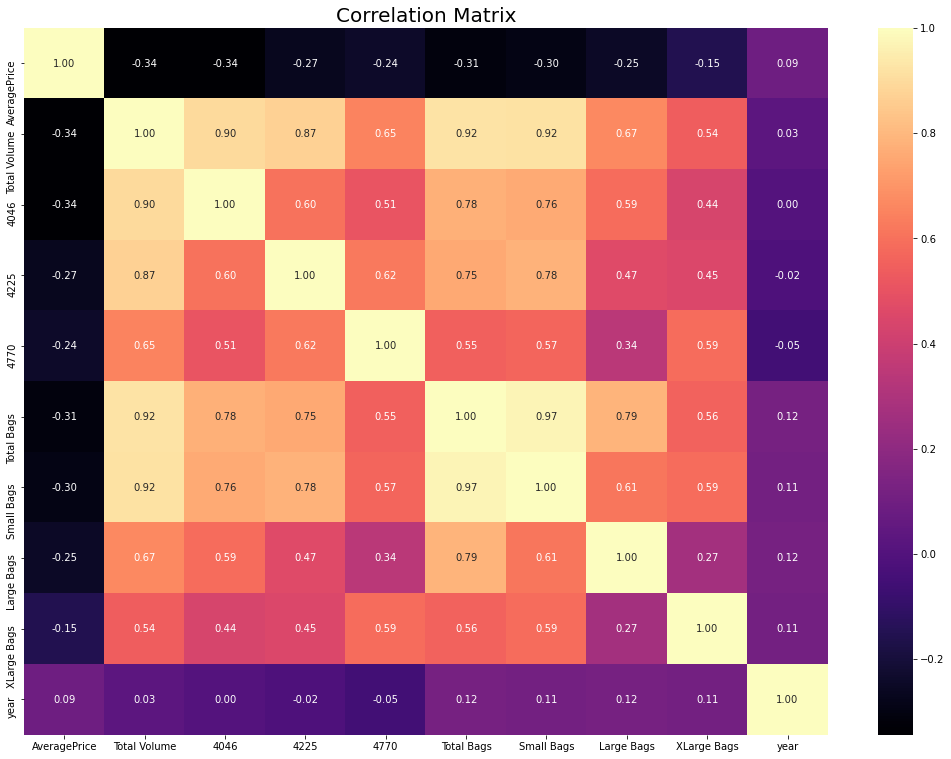

In [193]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

<AxesSubplot:xlabel='year', ylabel='count'>

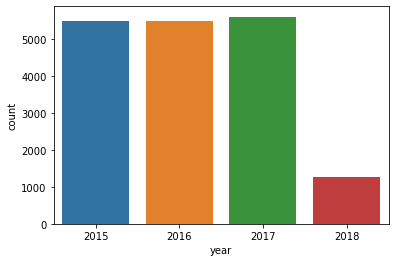

In [194]:
sns.countplot(x='year', data=df)

<AxesSubplot:xlabel='type', ylabel='count'>

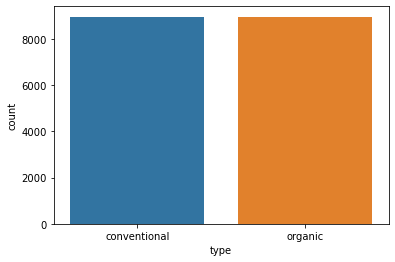

In [195]:
sns.countplot(x='type', data=df)

<AxesSubplot:xlabel='region', ylabel='count'>

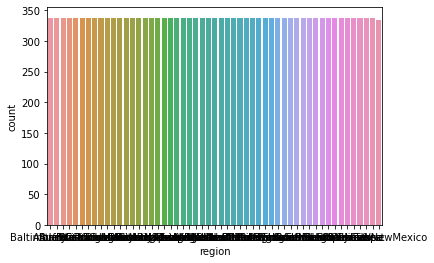

In [196]:
sns.countplot(x='region', data=df)

In [197]:
import pylab as pl

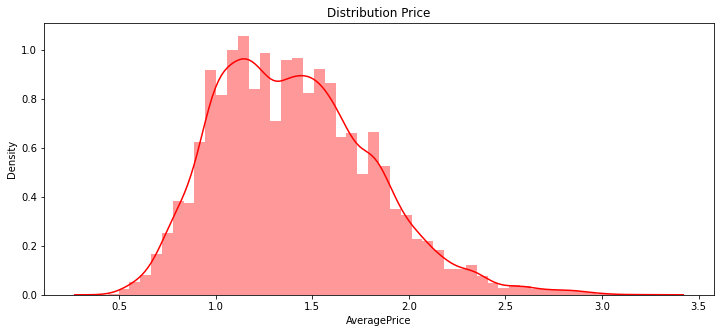

In [198]:
pl.figure(figsize=(12,5))
pl.title("Distribution Price")
ax = sns.distplot(df["AveragePrice"], color = 'r')

<AxesSubplot:xlabel='AveragePrice', ylabel='type'>

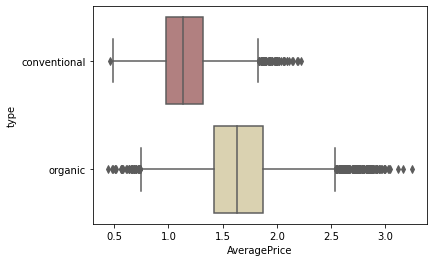

In [199]:
sns.boxplot(y="type", x="AveragePrice", data=df, palette = 'pink')

Organik doğal olandır. Bu açıdan fiyatının daha yüksek olması normal. Herkes organik yetiştirilmiş avokado sever. Yetiştirilme maliyetlerinden olsa gerek daha pahalı olduğunu görebiliyoruz.

In [200]:
avocado_by_date = df.groupby('Date').aggregate({'Total Volume':'sum',
                                                              '4046':'sum',
                                                              '4225':'sum',
                                                              '4770':'sum',
                                                              'Total Bags':'sum',
                                                              'Small Bags':'sum',
                                                              'Large Bags':'sum',
                                                              'XLarge Bags':'sum',
                                                             'AveragePrice':'mean'})

avocado_by_date.head(10)

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,AveragePrice
Date,,,,,,,,,
2015-01,197631691.530,79336639.900,81053469.690,5587649.440,31653932.500,26049127.220,5517142.170,87663.110,1.368
2015-02,225134159.050,94671624.480,89867941.340,6540088.810,34054504.420,28538925.260,5371263.410,144315.750,1.329
2015-03,259825758.550,108351412.150,100860105.560,7775792.510,42838448.330,36790497.760,5809689.920,238260.650,1.364
2015-04,213591902.680,92826601.070,78508706.650,5916726.700,36339868.260,30765391.890,5433857.150,140619.220,1.385
2015-05,301031891.080,131852878.090,111659791.060,8124002.060,49395219.870,41646142.140,7563420.790,185656.940,1.346
2015-06,237522655.770,100166545.730,85651068.580,7572964.860,44132076.600,37742137.090,6169096.180,220843.330,1.400
2015-07,221613018.870,87348228.990,86310713.400,7457001.250,40497075.230,34078033.990,6202564.570,216476.670,1.417
2015-08,261052990.890,100622161.410,108363140.210,8573694.310,43493994.960,36844712.260,6313531.140,335751.560,1.448
2015-09,204961010.120,66213702.750,96200534.630,7547348.780,34999423.960,26962609.140,7675108.280,361706.540,1.450


In [201]:
import plotly.express as px
px.line(x=avocado_by_date.index.to_timestamp(),
        y=avocado_by_date['AveragePrice'],
        title="Average Price by Date")

Yıllara göre incelediğimizde ortalama fiyatın en yüksek olduğu aylar Eylül ve Ekim ayıdır. Bu aylar Amerika'da avokado hasat zamanıdır.

In [202]:
px.line(x=avocado_by_date.index.to_timestamp(),
        y=avocado_by_date['Total Bags'],
        title="Total Bags by time")

In [203]:
avocado_by_region = df.groupby(['region']).aggregate({'Total Volume':'sum',
                                                              '4046':'sum',
                                                              '4225':'sum',
                                                              '4770':'sum',
                                                              'Total Bags':'sum',
                                                              'Small Bags':'sum',
                                                              'Large Bags':'sum',
                                                              'XLarge Bags':'sum',
                                                             'AveragePrice':'mean'})
avocado_by_region

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,AveragePrice
region,,,,,,,,,
Albany,16067799.970,616539.640,12715968.390,55037.330,2680254.610,2246944.730,389881.720,43429.160,1.561
Atlanta,88605118.850,49387501.370,10551856.510,105248.390,28560513.580,17442735.840,10839675.060,278101.680,1.338
BaltimoreWashington,134713919.320,12051801.740,83142216.440,4213755.070,35306146.070,34117612.920,981546.790,206985.360,1.534
Boise,14413187.750,6766593.570,1170048.640,1077134.290,5399412.250,4677932.590,711028.320,10449.340,1.348
Boston,97273984.830,1688178.200,72406314.130,1684015.700,21495476.800,19910427.540,1500167.270,84879.990,1.531
...,...,...,...,...,...,...,...,...,...
StLouis,32072833.330,13510852.190,3799460.500,26488.670,14736030.970,11931855.920,2579377.160,224797.890,1.431
Syracuse,10942667.680,331788.660,6390340.990,28110.580,4192427.450,3645651.410,505015.100,41761.940,1.520
Tampa,66004539.310,35747751.850,10721107.040,38989.510,19496691.910,10608074.340,8653437.840,235178.730,1.409


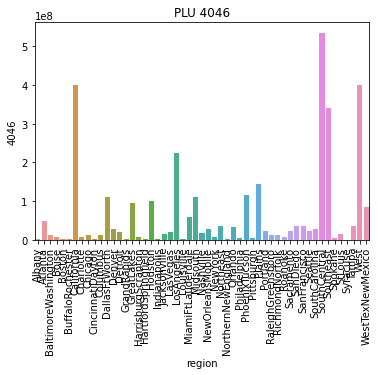

In [204]:
import seaborn as sns
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['4046']).set(title="PLU 4046")
plt.xticks(rotation=90)
plt.show()

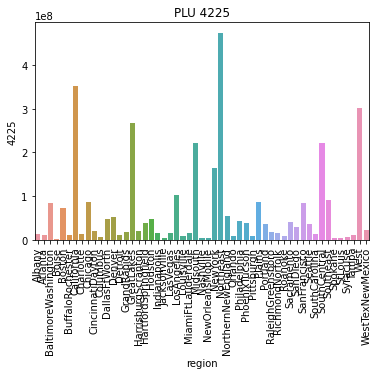

In [205]:
import seaborn as sns
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['4225']).set(title="PLU 4225")
plt.xticks(rotation=90)
plt.show()

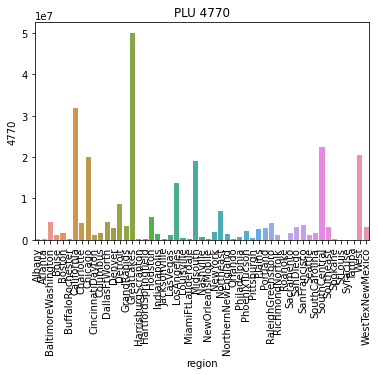

In [206]:
import seaborn as sns
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['4770']).set(title="PLU 4770")
plt.xticks(rotation=90)
plt.show()

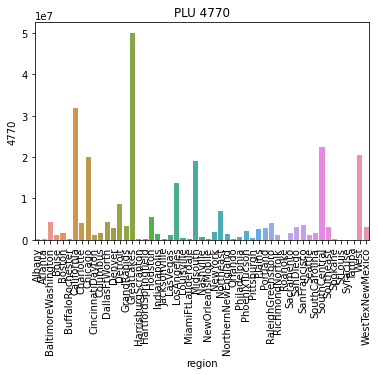

In [207]:
import seaborn as sns
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['4770']).set(title="PLU 4770")
plt.xticks(rotation=90)
plt.show()

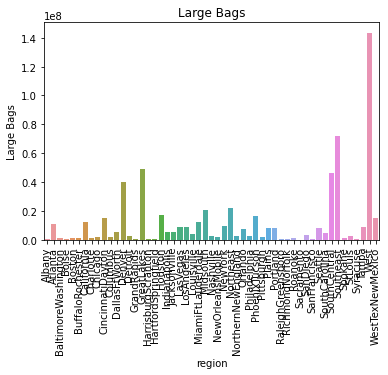

In [208]:
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['Large Bags']).set(title="Large Bags")
plt.xticks(rotation=90)
plt.show()

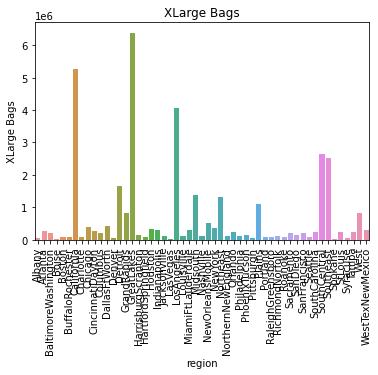

In [209]:
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['XLarge Bags']).set(title="XLarge Bags")
plt.xticks(rotation=90)
plt.show()

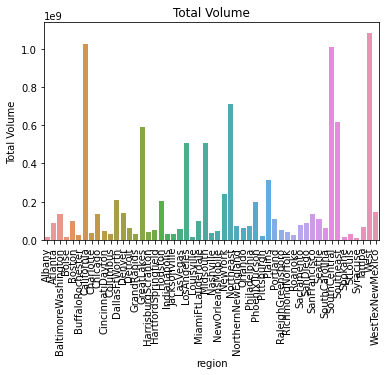

In [210]:
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['Total Volume']).set(title="Total Volume")
plt.xticks(rotation=90)
plt.show()

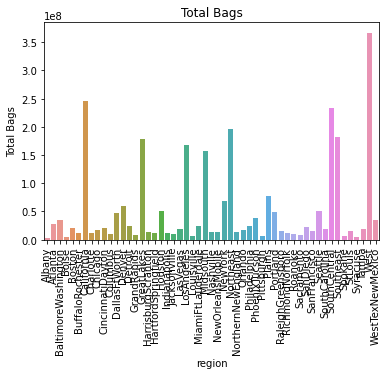

In [211]:
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['Total Bags']).set(title="Total Bags")
plt.xticks(rotation=90)
plt.show()

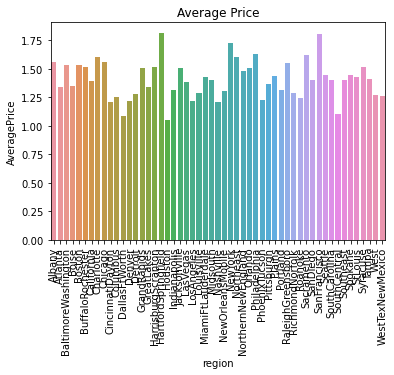

In [212]:
sns.barplot(x=avocado_by_region.index,y=avocado_by_region['AveragePrice']).set(title="Average Price")
plt.xticks(rotation=90)
plt.show()

In [215]:
df = pd.read_csv("avocado.csv")
df.drop(df.columns[0] , axis = 1 , inplace = True)
df = df[df.region != "TotalUS"]
df['Date'] = pd.to_datetime(df['Date'])
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 17911
Variables: 13
cat_cols: 2
num_cols: 10
cat_but_car: 1
num_but_cat: 1


In [216]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [217]:
for col in num_cols:
    print(col, check_outlier(df, col, q1=0.1, q3=0.9))

Date False
AveragePrice False
Total Volume True
4046 True
4225 True
4770 True
Total Bags True
Small Bags True
Large Bags True
XLarge Bags True


In [218]:
# AYKIRI DEĞERLERİ BASKILAMA
for col in num_cols:
    if check_outlier(df, col, q1=0.05, q3=0.95):
        replace_with_thresholds(df, col, q1=0.05, q3=0.95)

for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

Date False
AveragePrice False
Total Volume False
4046 False
4225 False
4770 False
Total Bags False
Small Bags False
Large Bags False
XLarge Bags False


In [219]:
df = pd.get_dummies(df, columns=["year"], drop_first=True)

In [220]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [221]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['type']

In [222]:
from sklearn.preprocessing import LabelEncoder

In [223]:
for col in binary_cols:
    df = label_encoder(df, col)

In [224]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,year_2016,year_2017,year_2018
0,2015-12-27,1.330,64236.620,1036.740,54454.850,48.160,8696.870,8603.620,93.250,0.000,0,Albany,0,0,0
1,2015-12-20,1.350,54876.980,674.280,44638.810,58.330,9505.560,9408.070,97.490,0.000,0,Albany,0,0,0
2,2015-12-13,0.930,118220.220,794.700,109149.670,130.500,8145.350,8042.210,103.140,0.000,0,Albany,0,0,0
3,2015-12-06,1.080,78992.150,1132.000,71976.410,72.580,5811.160,5677.400,133.760,0.000,0,Albany,0,0,0
4,2015-11-29,1.280,51039.600,941.480,43838.390,75.780,6183.950,5986.260,197.690,0.000,0,Albany,0,0,0


In [225]:
from datetime import datetime

In [226]:
df["week"]=df.Date.dt.week
df["month"]=df.Date.dt.month

In [227]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,year_2016,year_2017,year_2018,week,month
0,2015-12-27,1.330,64236.620,1036.740,54454.850,48.160,8696.870,8603.620,93.250,0.000,0,Albany,0,0,0,52,12
1,2015-12-20,1.350,54876.980,674.280,44638.810,58.330,9505.560,9408.070,97.490,0.000,0,Albany,0,0,0,51,12
2,2015-12-13,0.930,118220.220,794.700,109149.670,130.500,8145.350,8042.210,103.140,0.000,0,Albany,0,0,0,50,12
3,2015-12-06,1.080,78992.150,1132.000,71976.410,72.580,5811.160,5677.400,133.760,0.000,0,Albany,0,0,0,49,12
4,2015-11-29,1.280,51039.600,941.480,43838.390,75.780,6183.950,5986.260,197.690,0.000,0,Albany,0,0,0,48,11


# BASE MODELS

In [228]:
X = df.drop(['type','region','Date'], axis = 1)
y = df.type

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0)

In [230]:
def all_models(X, y, test_size=0.2, random_state=12345, classification=True):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
        roc_auc_score, confusion_matrix, classification_report, plot_roc_curve, mean_squared_error

    # Tum Base Modeller (Classification)
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from catboost import CatBoostClassifier
    from lightgbm import LGBMClassifier
    from sklearn.svm import SVC

    # Tum Base Modeller (Regression)
    from catboost import CatBoostRegressor
    from lightgbm import LGBMRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.svm import SVR
    from sklearn.tree import DecisionTreeRegressor
    from xgboost import XGBRegressor

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)
    all_models = []

    if classification:
        models = [('LR', LogisticRegression(random_state=random_state)),
                  ('KNN', KNeighborsClassifier()),
                  ('CART', DecisionTreeClassifier(random_state=random_state)),
                  ('RF', RandomForestClassifier(random_state=random_state)),
                  ('SVM', SVC(gamma='auto', random_state=random_state)),
                  ('XGB', GradientBoostingClassifier(random_state=random_state)),
                  ("LightGBM", LGBMClassifier(random_state=random_state)),
                  ("CatBoost", CatBoostClassifier(verbose=False, random_state=random_state))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            acc_train = accuracy_score(y_train, y_pred_train)
            acc_test = accuracy_score(y_test, y_pred_test)
            values = dict(name=name, acc_train=acc_train, acc_test=acc_test)
            all_models.append(values)

        sort_method = False
    else:
        models = [('LR', LinearRegression()),
                  ("Ridge", Ridge()),
                  ("Lasso", Lasso()),
                  ("ElasticNet", ElasticNet()),
                  ('KNN', KNeighborsRegressor()),
                  ('CART', DecisionTreeRegressor()),
                  ('RF', RandomForestRegressor()),
                  ('SVR', SVR()),
                  ('GBM', GradientBoostingRegressor()),
                  ("XGBoost", XGBRegressor()),
                  ("LightGBM", LGBMRegressor()),
                  ("CatBoost", CatBoostRegressor(verbose=False))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            values = dict(name=name, RMSE_TRAIN=rmse_train, RMSE_TEST=rmse_test)
            all_models.append(values)

        sort_method = True
    all_models_df = pd.DataFrame(all_models)
    all_models_df = all_models_df.sort_values(all_models_df.columns[2], ascending=sort_method)
    print(all_models_df)
    return all_models_df


all_models = all_models(X, y, test_size=0.2, random_state=46, classification=False)

          name  RMSE_TRAIN  RMSE_TEST
11    CatBoost       0.032      0.064
10    LightGBM       0.040      0.077
6           RF       0.028      0.077
9      XGBoost       0.017      0.085
8          GBM       0.100      0.114
5         CART       0.000      0.116
4          KNN       0.103      0.132
7          SVR       0.242      0.245
0           LR       0.361      0.365
1        Ridge       0.361      0.365
2        Lasso       0.438      0.443
3   ElasticNet       0.438      0.443


In [231]:
##########################
# RANDOM FORESTS MODEL TUNING
##########################

# Tuning için hazırlanan parametreler. Tuning zaman aldığı için çıkan parametre değerlerini girdim.
rf_params = {"max_depth": [4, 5, 7, 10],
             "max_features": [4, 5, 6, 8, 10, 12],
             "n_estimators": [80, 100, 150, 250, 400, 500],
             "min_samples_split": [8, 10, 12, 15]}

# rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1).fit(X_train , y_train)
# rf_cv_model.best_params_

best_params = {'max_depth': 10,
               'max_features': 8,
               'min_samples_split': 10,
               'n_estimators': 80}

rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

# RANDOM FORESTS TUNED MODEL
rf_tuned = RandomForestRegressor(max_depth=10, max_features=4, n_estimators=150,
                                 min_samples_split=8, random_state=42).fit(X_train, y_train)

# TUNED MODEL TRAIN HATASI
y_pred = rf_tuned.predict(X_train)

print("RF Tuned Model Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

##########################
# TUNED MODEL TEST HATASI
##########################

y_pred = rf_tuned.predict(X_test)
print("RF Tuned Model Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RF Tuned Model Train RMSE: 0.055720706421820775
RF Tuned Model Test RMSE: 0.08470177093623289


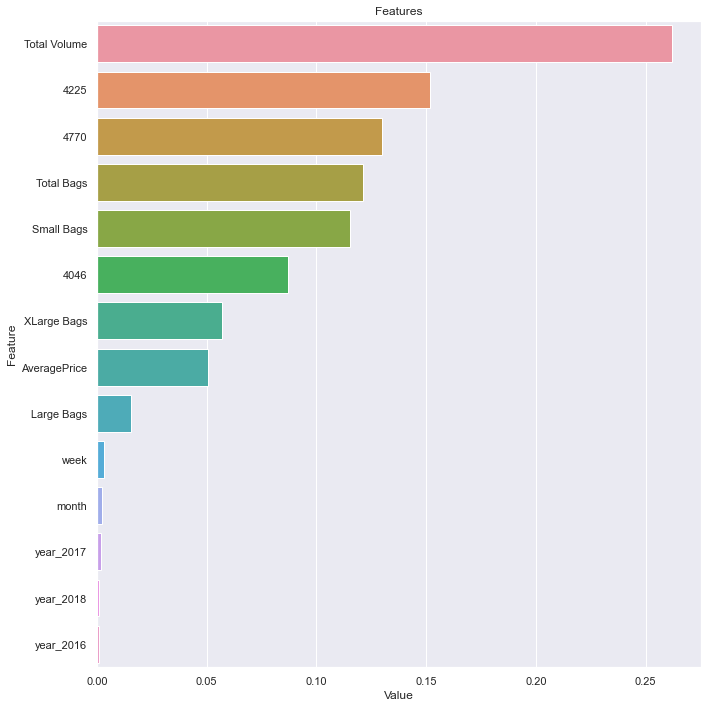

In [232]:
#######################################
# FEATURE IMPORTANCE
#######################################

def plot_importance(model, features, num=len(X), save=False):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_tuned, X_train)

In [233]:
# Tuned edilmiş model nesnesinin kaydedilmesi
import pickle
pickle.dump(rf_tuned, open("rf_final_model.pkl", 'wb'))

# Tuned edilmiş model nesnesinin yüklenmesi
df_prep = pickle.load(open('rf_final_model.pkl', 'rb'))

Çalışmamı okumaya ayırdığınız zaman için çok teşekkür ederim. Umarım sizin için ilginç ve biraz yardımcı olmuştur.